# Plotting the effect of every hyperparameter on the test results, and more

This is an analysis for the testing (validation) accuracies in function of every hyperparameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from functools import partial
import json
import os
import pprint

pp = pprint.PrettyPrinter(indent=4, width=100)

In [2]:
dataset_name = "UCIHAR"
results_folder_path = os.path.join("results", dataset_name)
results = sorted(os.listdir(results_folder_path))
results

['model_0.166610111978283_347bb.txt.json',
 'model_0.18052256532066507_0331d.txt.json',
 'model_0.18052256532066507_24de4.txt.json',
 'model_0.18052256532066507_7ece5.txt.json',
 'model_0.18052256532066507_bbc7b.txt.json',
 'model_0.18221920597217509_6ba21.txt.json',
 'model_0.3481506616898541_5eabb.txt.json',
 'model_0.3481506616898541_ff04c.txt.json',
 'model_0.3488293179504581_ae6b4.txt.json',
 'model_0.36206311503223615_82548.txt.json',
 'model_0.3630810994231422_820c5.txt.json',
 'model_0.40583644384119444_f228b.txt.json',
 'model_0.4180522565320665_9efd1.txt.json',
 'model_0.4353579911774686_ff9fa.txt.json']

In [3]:
# Load results from disk
jsons = []
for file_name in results:
    file_path = os.path.join(results_folder_path, file_name)
    with open(file_path) as f:
        j = json.load(f)
    jsons.append(j)

print("Here are some useful keys in our dict/json structure:")    
pp.pprint(list(jsons[0].keys()))
pp.pprint(list(jsons[0]["history"].keys()))
pp.pprint(jsons[0]["space"])

Here are some useful keys in our dict/json structure:
[   'best_train_accuracy',
    'best_train_f1_score',
    'best_validation_accuracy',
    'best_validation_f1_score',
    'dataset_name',
    'history',
    'loss',
    'model_name',
    'real_best_loss',
    'space',
    'status',
    'true_loss',
    'true_loss_variance']
[   'train_accuracies',
    'train_f1_scores',
    'train_losses',
    'validation_accuracies',
    'validation_f1_scores',
    'validation_losses']
{   'batch_size': 64,
    'dropout_drop_proba': 0.2983198171511765,
    'hidden_size': 44,
    'is_stacked_residual': False,
    'l2_weight_reg': 0.018323072377183863,
    'larnn_mode': 'residual',
    'learning_rate': 0.0007800036423629956,
    'num_layers': 2,
    'training_epochs': 80,
    'use_BN': True,
    'use_positional_encoding': False}


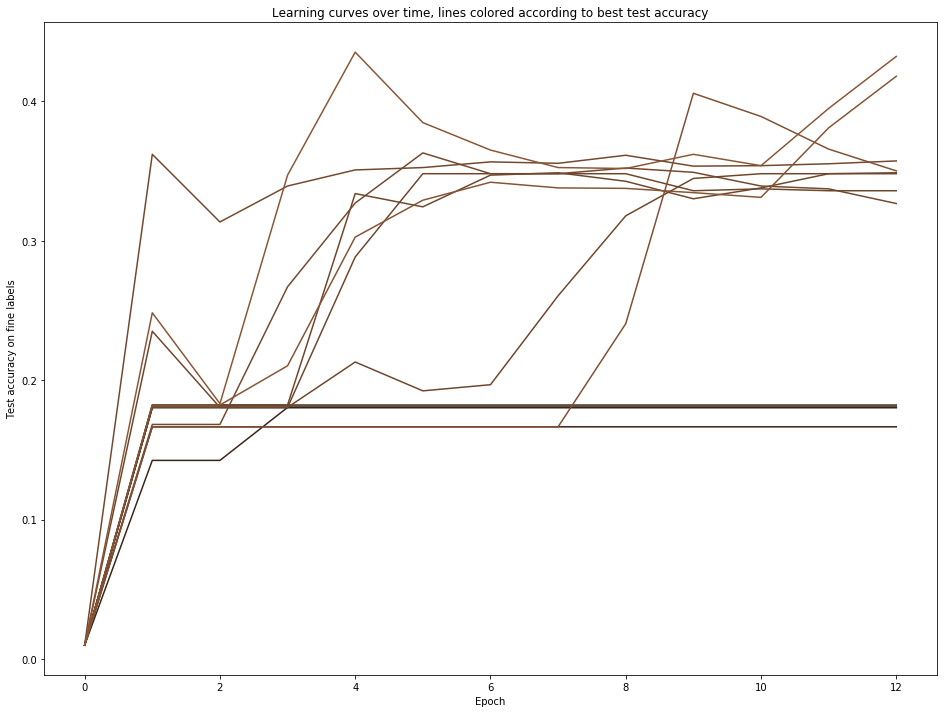

In [4]:
plt.figure(figsize=(16, 12))
for neural_net in jsons:
    accuracy = [1.0/100] + neural_net["history"]["validation_accuracies"]
    final_accuracy = neural_net["best_validation_accuracy"]
    plt.plot(accuracy, color=cm.copper(final_accuracy))

plt.xlabel('Epoch')
plt.ylabel('Test accuracy on fine labels')
plt.title("Learning curves over time, lines colored according to best test accuracy")
plt.show()

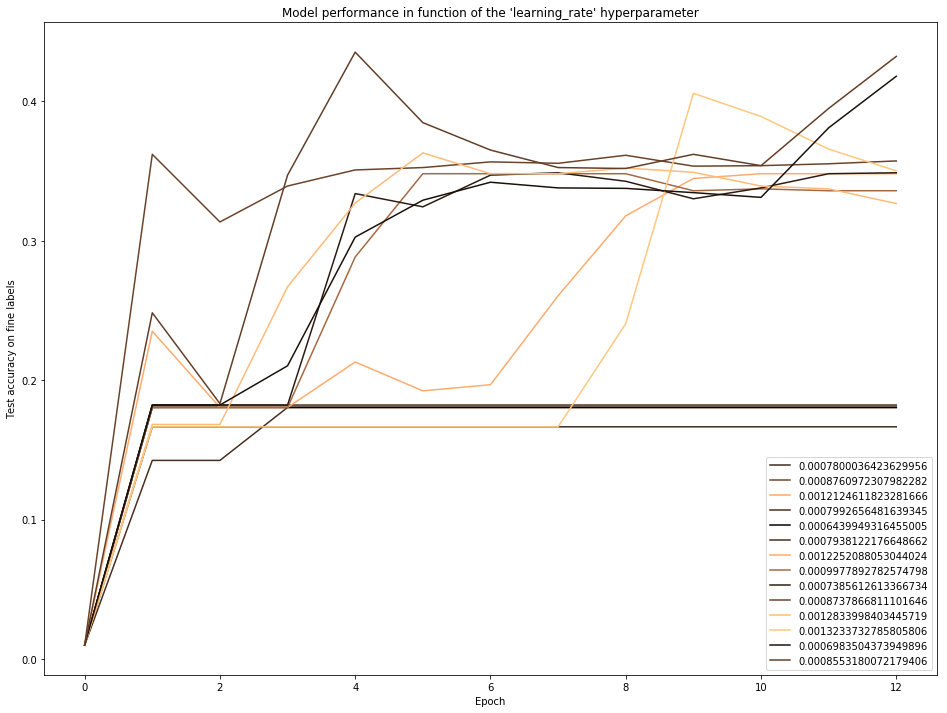

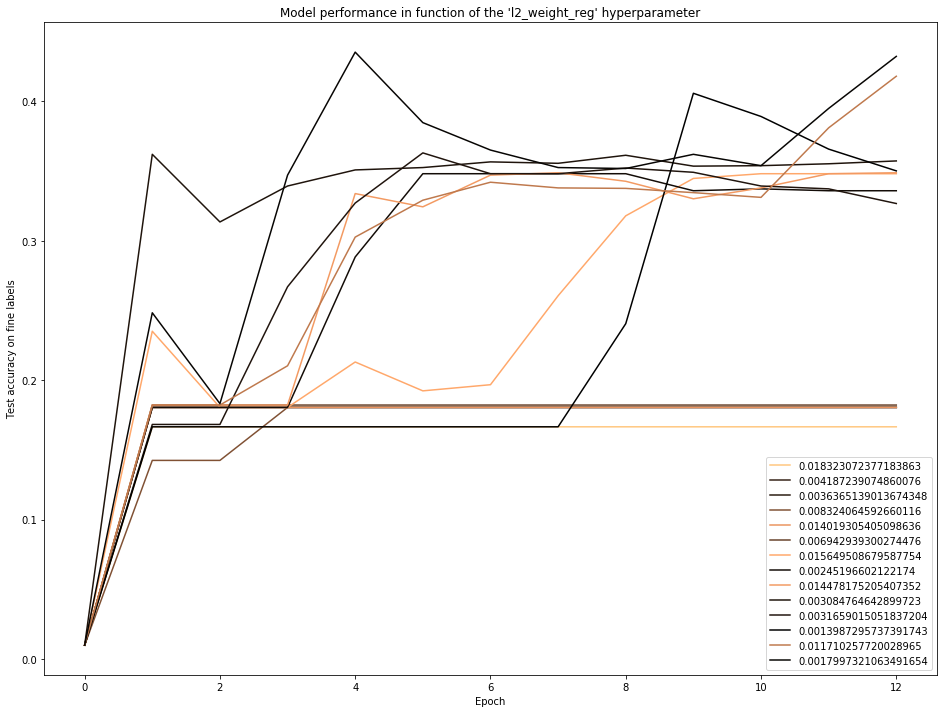

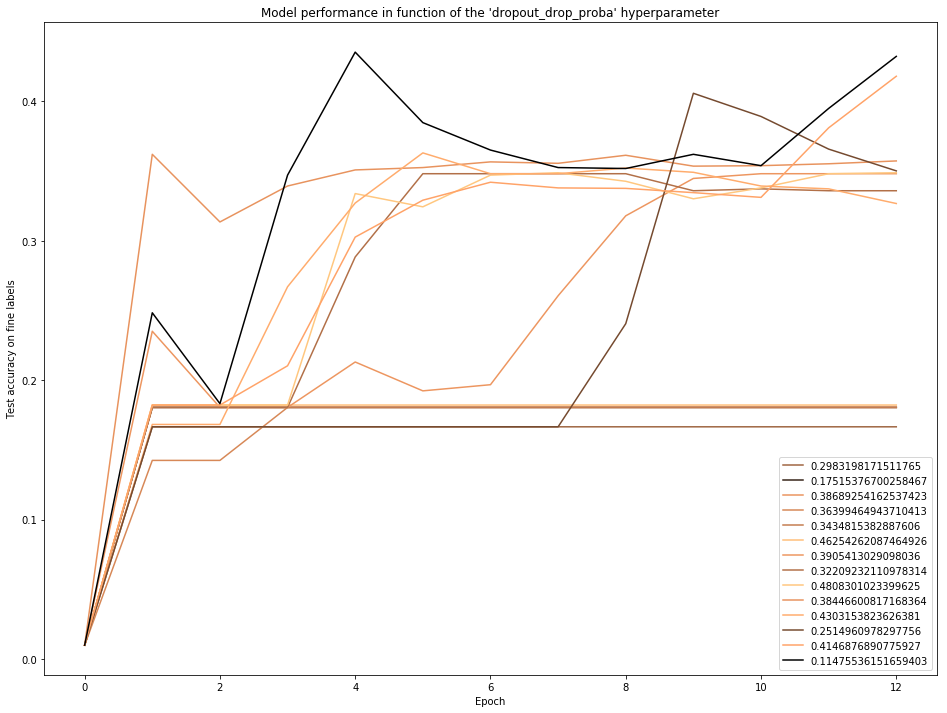

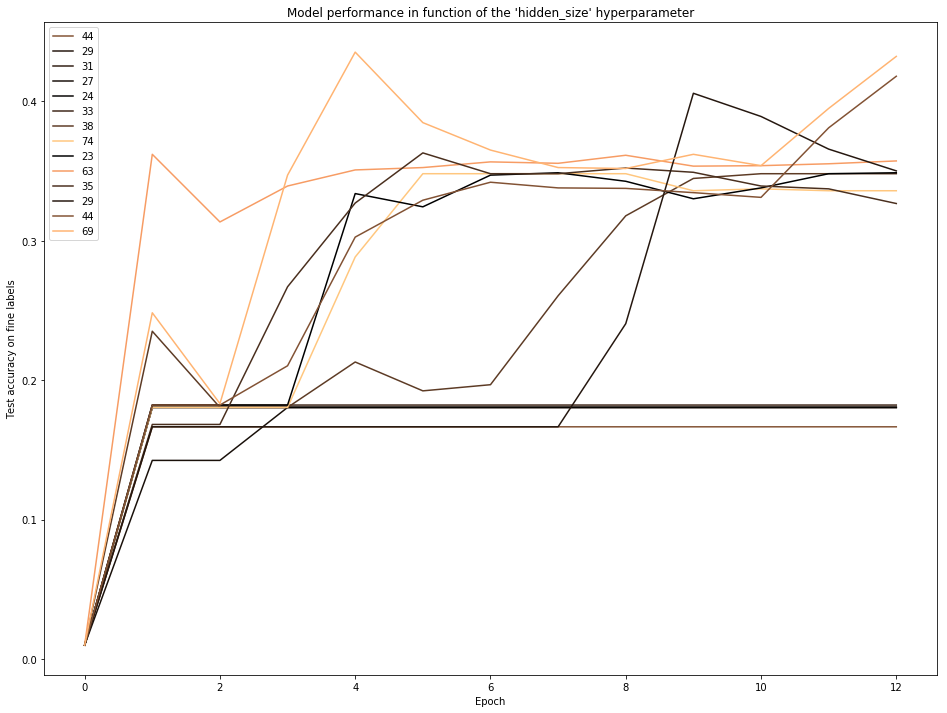

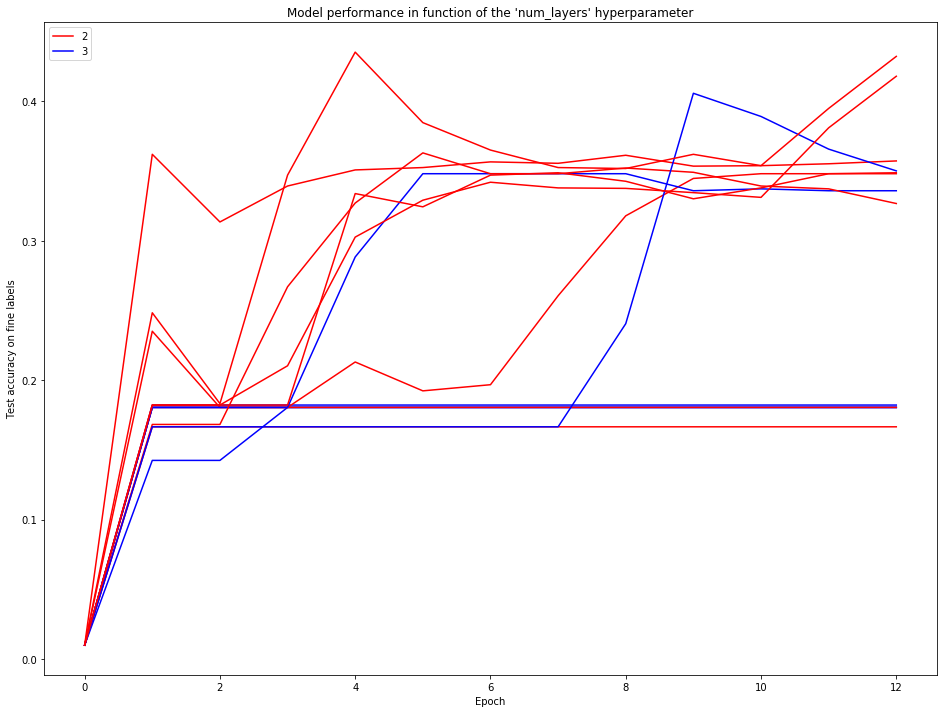

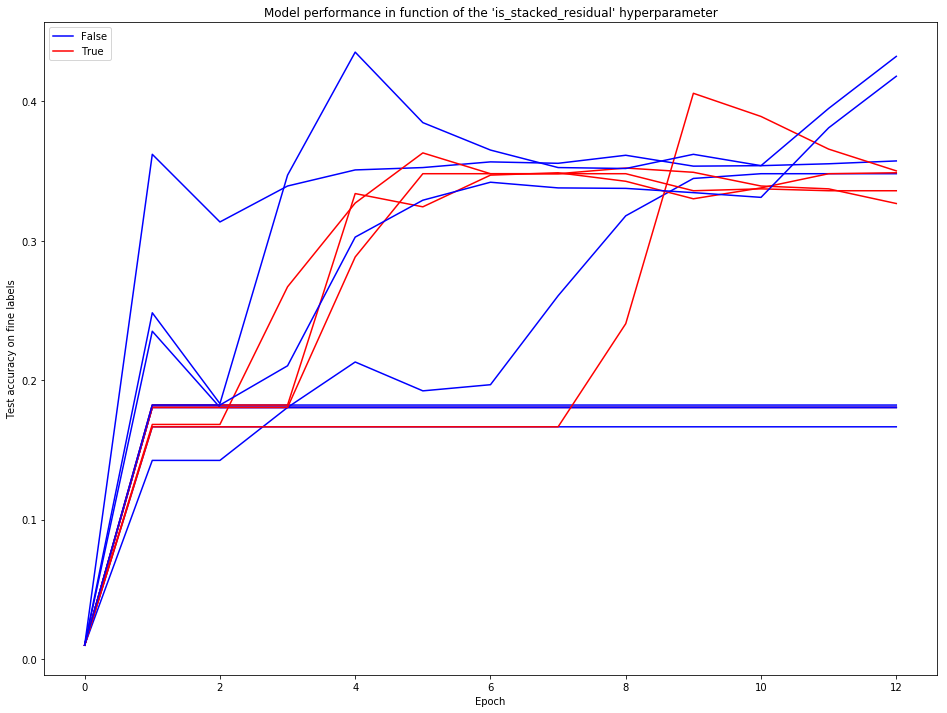

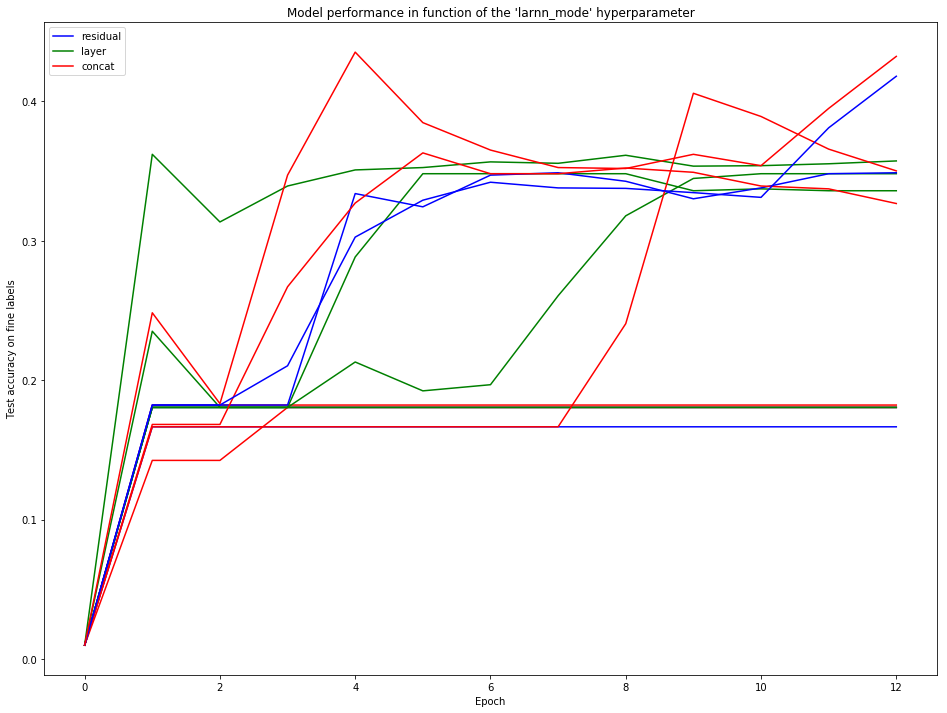

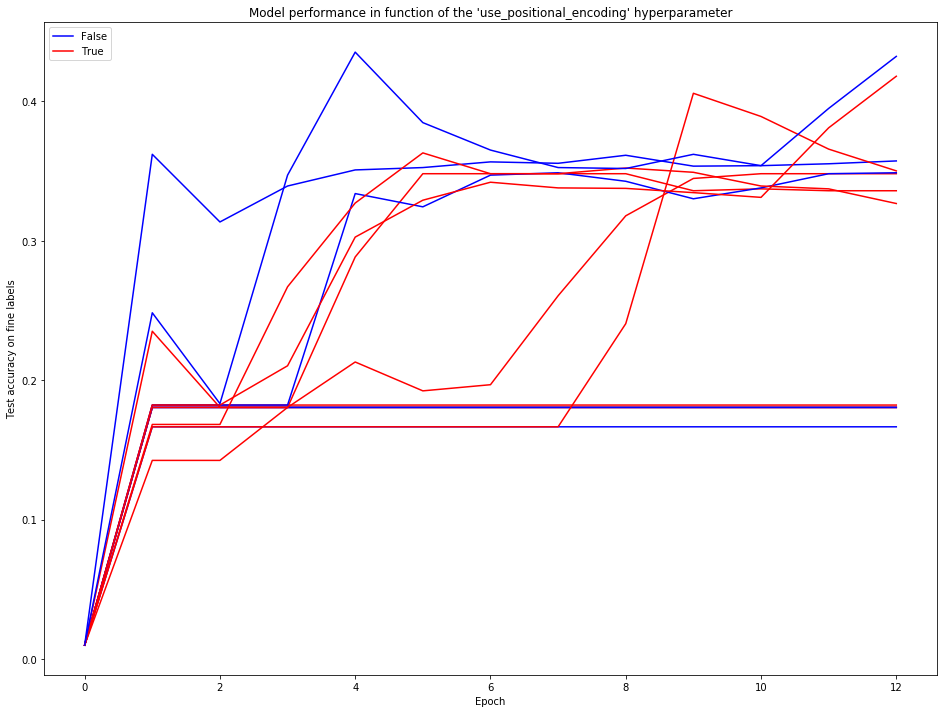

In [5]:
def plot_discrete_set(accs, key_name, key_values):
    plt.figure(figsize=(16, 12))
    
    key_values = [str(i) for i in key_values]

    colors = ["red", "blue", "green", "cyan", "magenta", "yellow", "black"]
    colors_mapping = {x: colors[i] for i, x in enumerate(set(key_values))}
    
    already_used_labels = set()
    for accuracy, val in zip(accs, key_values):
        if val in already_used_labels:
            plt.plot(accuracy, color=colors_mapping[val])
        else:
            plt.plot(accuracy, color=colors_mapping[val], label=val)
            already_used_labels.update({val})

    plt.xlabel('Epoch')
    plt.ylabel('Test accuracy on fine labels')
    plt.title("Model performance in function of the '{}' hyperparameter".format(key_name))
    plt.legend()
    plt.show()

def plot_number(accs, key_name, key_values):
    plt.figure(figsize=(16, 12))
    orig_kv = list(key_values)
    
    tmp_kval = [k for k in key_values if k is not None]
    min_val = min(tmp_kval)
    max_val = max(tmp_kval)
    for i, kv in enumerate(key_values):
        if kv is None:
            key_values[i] = "black"
            continue
        kv -= min_val
        kv = kv / (max_val - min_val)
        key_values[i] = float(kv)
    
    for accuracy, color, key_value in zip(accs, key_values, orig_kv):
        if type(color) is float: 
            color = cm.copper(color)
            plt.plot(accuracy, color=color, label=str(key_value))
        else:
            plt.plot(accuracy, color="black")
    
    plt.xlabel('Epoch')
    plt.ylabel('Test accuracy on fine labels')
    plt.title("Model performance in function of the '{}' hyperparameter".format(key_name))
    plt.legend()
    plt.show()

plot_function_map_from_key = {
    'learning_rate': plot_number,
    'l2_weight_reg': plot_number,
    'dropout_drop_proba': plot_number,
    'hidden_size': plot_number,
    'attention_heads': plot_number,
    'num_layers': plot_discrete_set,
    'is_stacked_residual': plot_discrete_set,
    'larnn_window_size': plot_number,
    'larnn_mode': plot_discrete_set,
    'use_positional_encoding': plot_discrete_set
}

for key, plot_func in plot_function_map_from_key.items():    
    accs = [
        [1.0/100] + neural_net["history"]["validation_accuracies"] for neural_net in jsons
    ]
    key_values = [
        neural_net["space"][key] for neural_net in jsons
    ]
    plot_func(accs, key, key_values)

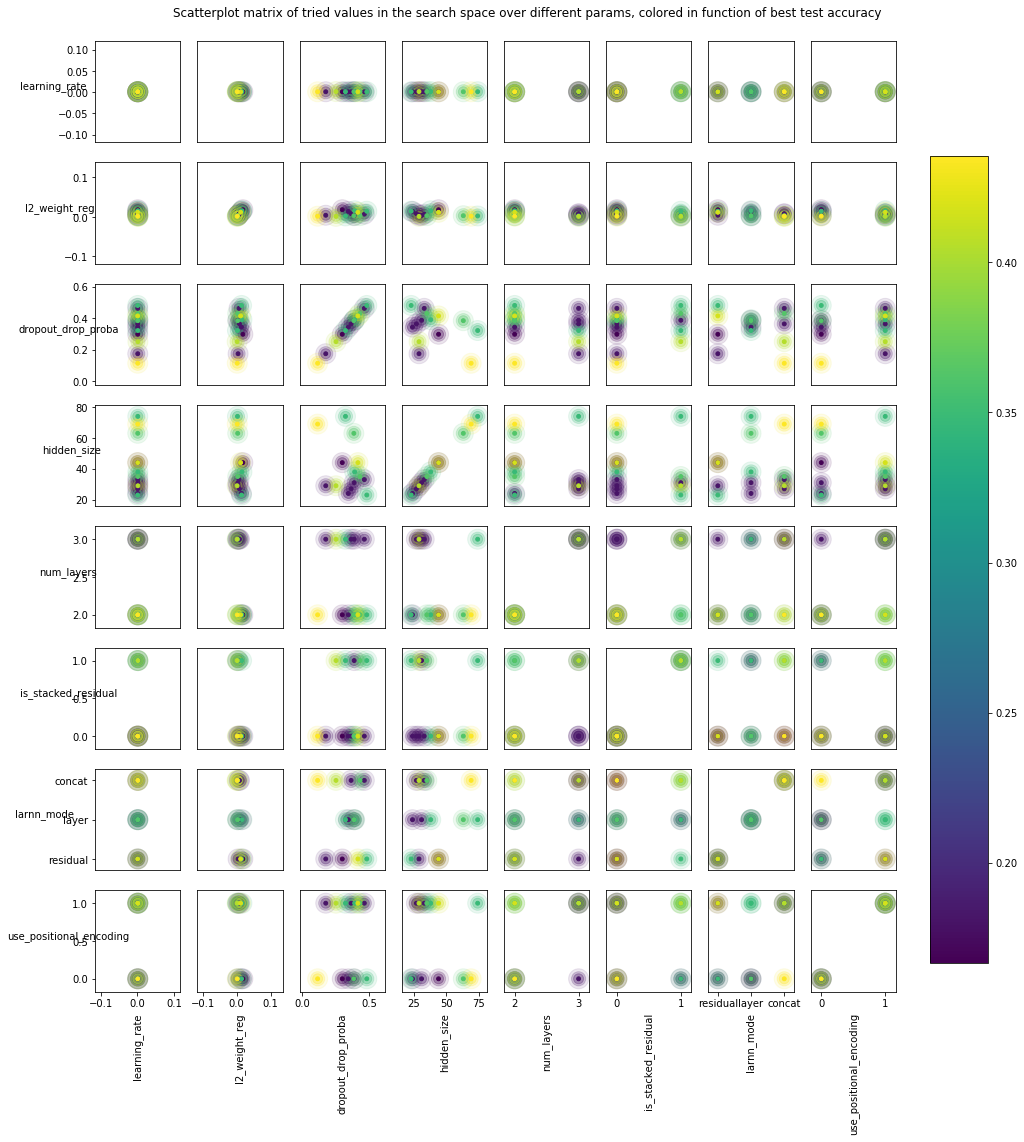

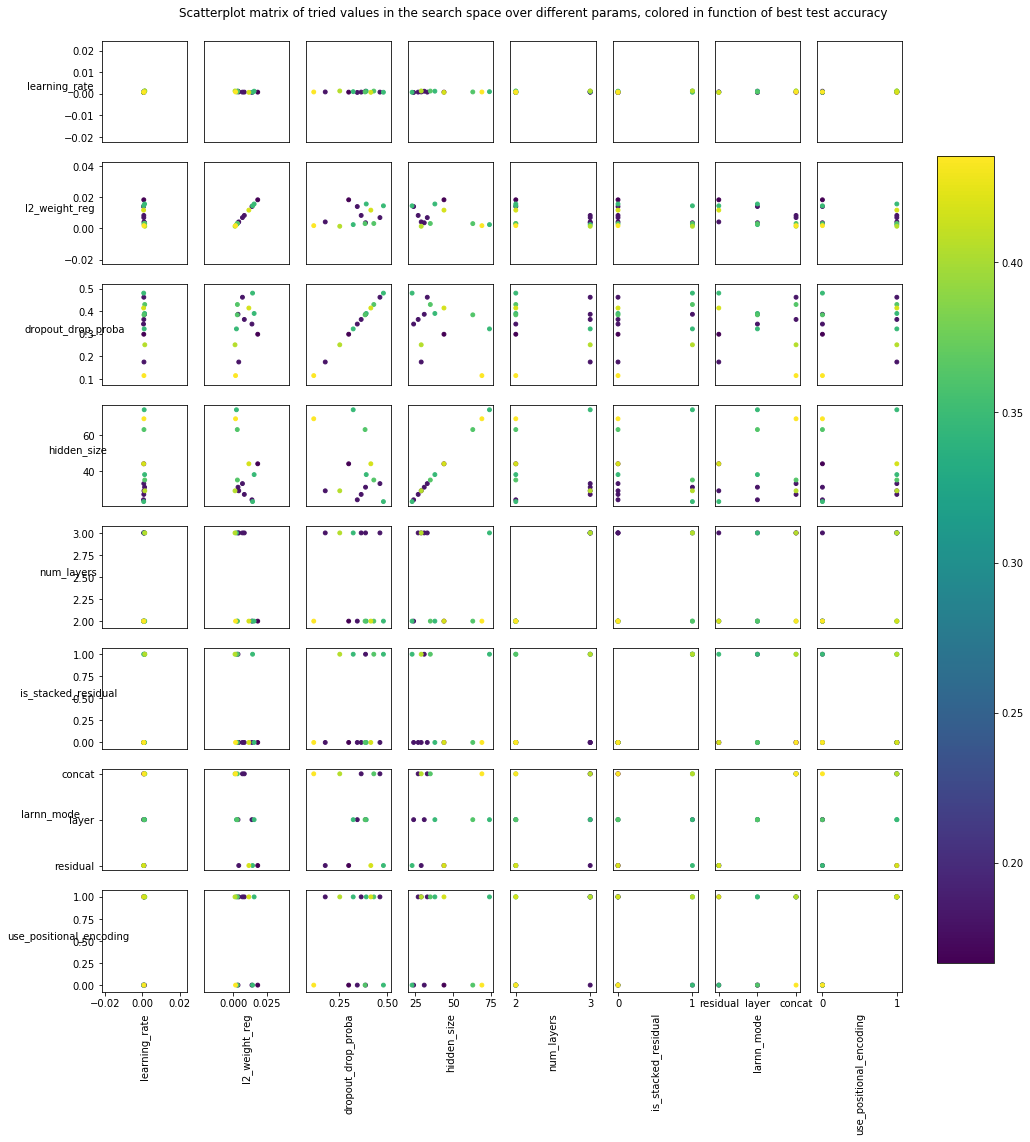

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# We chose just a few params to inspect not to bloat the scatterplot:
int_params_names_to_correlate = [
    'learning_rate',
    'l2_weight_reg',
    'dropout_drop_proba',
    'hidden_size',
    'attention_heads',
    'num_layers',
    'is_stacked_residual',
    'larnn_window_size',
    'larnn_mode',
    'use_positional_encoding'
]

params_values = [[neural_net["space"][p] for neural_net in jsons] for p in int_params_names_to_correlate]
best_accs = [neural_net["best_validation_accuracy"] for neural_net in jsons]


def scatterplot_matrix_colored(params_names, params_values, best_accs, blur=False):
    """Scatterplot colored according to the Z values of the points."""
    
    nb_params = len(params_values)
    best_accs = np.array(best_accs)
    norm = matplotlib.colors.Normalize(vmin=best_accs.min(), vmax=best_accs.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))#, facecolor=bg_color, edgecolor=fg_color)
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            # Subplot:
            if blur:
                s = axes.scatter(p2, p1, s=400, alpha=.1,
                                 c=best_accs, cmap='viridis', norm=norm)
                s = axes.scatter(p2, p1, s=200, alpha=.2,
                                 c=best_accs, cmap='viridis', norm=norm)
                s = axes.scatter(p2, p1, s=100, alpha=.3,
                                 c=best_accs, cmap='viridis', norm=norm)
            s = axes.scatter(p2, p1, s=15,
                             c=best_accs, cmap='viridis', norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored in function of best test accuracy')
    plt.show()

# We plot a blurred and a non-blurred version in case the blurred version is too coarse / not enough fine
scatterplot_matrix_colored(int_params_names_to_correlate, params_values, best_accs, blur=True)
scatterplot_matrix_colored(int_params_names_to_correlate, params_values, best_accs, blur=False)


Not plotting with some built-in functions.
Remember that the loss is the negative of the test accuracy.

avg best error: -0.4353579911774686


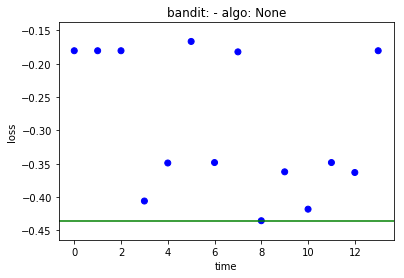

Showing Histogram of 14 jobs


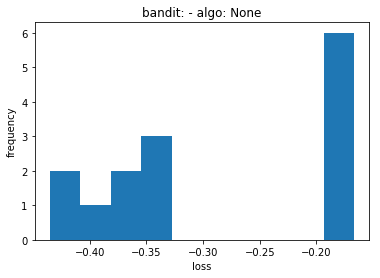

In [7]:
from hyperopt.plotting import main_plot_history, main_plot_histogram

import pickle 

with open(results_folder_path + ".pkl", "rb") as f:
    trials = pickle.load(f)

print("Not plotting with some built-in functions.")
print("Remember that the loss is the negative of the test accuracy.\n")

main_plot_history(trials)
main_plot_histogram(trials)

Note: the current notebook is adapted from the [Hyperopt Keras CNN CIFAR 100 project](https://github.com/Vooban/Hyperopt-Keras-CNN-CIFAR-100). The original file is licensed under the MIT License, Copyright (c) 2017 Vooban Inc. It is here sublicensed under the MIT License, Copyright (c) 2018 Guillaume Chevalier, as part of the [LARNN project](https://github.com/guillaume-chevalier/Linear-Attention-Recurrent-Neural-Network).